# CLIP-DINOiser visualization demo 🖼️

In [1]:
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np
from operator import itemgetter 
import torch
import warnings
warnings.filterwarnings('ignore')
initialize(config_path="configs", version_base=None)


/home/ulindu/.conda/envs/clipdino/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ulindu/.conda/envs/clipdino/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


hydra.initialize()

In [2]:
def visualize_per_image(file_path, text_prompts, palette, model):
    assert os.path.isfile(file_path), f"No such file: {file_path}"

    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    h, w = img_tens.shape[-2:]
    output = model(img_tens).cpu()
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear",
                           align_corners=False)[..., :h, :w]
    output = output[0].argmax(dim=0)
    mask = mask2rgb(output, palette)

    fig = plt.figure(figsize=(3, 1))
    classes = np.unique(output).tolist()
    plt.imshow(np.array(itemgetter(*classes)(PALETTE)).reshape(1, -1, 3))
    plt.xticks(np.arange(len(classes)), list(itemgetter(*classes)(text_prompts)), rotation=45)
    plt.yticks([])

    return mask, fig, img

### Load and configure a model

In [6]:
descriptor_json = '/home/ulindu/kavindu/Seg-TTO/clip-dinoiser/descriptors/voc_2012_sem_seg_val_bg.json'
check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = "cuda"
cfg.model.json_path = descriptor_json
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates=False # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()

Initializing the contect with given words: [a_photo_of_a]
Initializing the contect with given words: [a_photo_of_a_clean]
Initializing the contect with given words: [a_close-up_photo_of_a]
Initializing the contect with given words: [a_blurry_photo_of_the]
Initializing the contect with given words: [a_bright_photo_of_a]
Random initialization: initializing a learnable class token
=> Model created: visual backbone ViT-B/32
=> Using native Torch AMP. Training in mixed precision.
CLIP-DINOiser config: /home/ulindu/kavindu/Seg-TTO/clip-dinoiser/descriptors/voc_2012_sem_seg_val_bg.json


### Example with 'background' class

In [7]:
file = 'assets/vintage_bike.jpeg'
PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# specify your prompts
TEXT_PROMPTS = ['background', 'vintage bike', 'leather bag']
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# set apply FOUND (background detector) to True
model.apply_found = True

# run segmentation
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha) * mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

RuntimeError: stack expects each tensor to be equal size, but got [3, 382, 564] at entry 0 and [3, 448, 448] at entry 1

### Example without 'background' class

(-0.5, 1449.5, 793.5, -0.5)

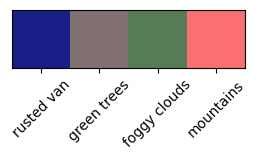

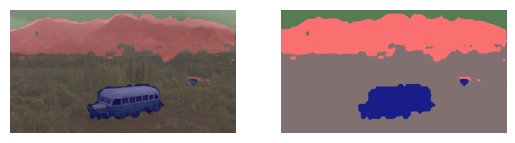

In [12]:
file = 'assets/rusted_van.png'

PALETTE = [[25, 29, 136], [128, 112, 112], [85, 124, 85], [250, 112, 112], [250, 250, 0], [250, 0, 0]]

# specify TEXT PROMPTS
TEXT_PROMPTS = ["rusted van", "green trees", "foggy clouds", "mountains"] 
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# specify whether applying FOUND or not
model.apply_found = False
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha)*mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
